# Re-useable Component: Multi-line time series plot

This component is defined with the following parts:  

1. **data**: the data to be plotted is in a dataframe where the first column is the x-axis and the remaining columns are values to be plotted on the y-axis 
2. **settings**: dictionary for all annotations and stylings, e.g. axis labels, shaded areas, colours, text rotation angle, etc.  


In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import math
# import rick
import geopandas as gpd
import os
import shapely
from shapely.geometry import Point
#os.environ["PROJ_LIB"]=r"C:\Users\rliu4\AppData\Local\Continuum\anaconda3\Library\share"
import importlib
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib.dates as mdates
from matplotlib.lines import Line2D # for legend

import seaborn as sns
from pandas.plotting import parallel_coordinates

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Config

In [3]:
# CONFIG=configparser.ConfigParser()
# CONFIG.read('/home/nangini/db_local.cfg')
# dbset=CONFIG['DBSETTINGS']
# con=connect(**dbset)
# i=0

# JUPYTERHUB
CONFIG=configparser.ConfigParser()
CONFIG.read('/home/nangini/db_local.cfg')
dbset=CONFIG['DBSETTINGS']
con=connect(**dbset)
i=0

# Palette
Might be useful to have a collection of colours.   

In [4]:
# Line colours
rick_purple='#660159'
rick_purple_light='#d1b2cd'
rick_grey='#7f7e7e' # colour.grey
rich_orange='#D95F02'
rich_orange_light='#F3CAAC'

# Shaded area colours
rich_facecolour='#e1e1e1'

# Multi-line reusable component

In [5]:
# font_manager.FontProperties(family='Libre Franklin',size=9)

In [6]:
def multi_linechart(df_orig, sett):
    '''Creates a line chart. Number of lines to be plotted determined
    from input data.
    x axis must be modified manually
    
    Parameters
    -----------
    df : pandas dataframe
        Data for the line chart.
    sett: settings object containing styling and annotation parameters      
    
    Optional params:
    
    
    Returns 
    --------
    fig
        Matplotlib fig object
    ax 
        Matplotlib ax object
 
    ''' 
    df=df_orig.copy()
    
    # ----------------------------------------------
    # Setup the figure
    fig, ax =plt.subplots(1)
    fig.set_size_inches(18, 5)
    ax = plt.gca()
    ax.tick_params(width=1, length=2)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # comma format
    
    
    # ----------------------------------------------
    # Styling params if not defined in sett
    fontsize=9 if 'font-size' not in sett['body'] else sett['body']['font-size']
    stroke='#000000'
    stroke_width=2
    border='solid'
    mpl.rcParams['axes.linewidth'] = 0.3
    mpl.rcParams['font.family'] = ('Libre Franklin' if 'font-family' not in 
                                  sett['body'] else sett['body']['font-family'])
    
    plt.grid(b=True, which='major', color='gray', linestyle='-')
    plt.grid(b=True, which='minor', color='#D3D3D3', linestyle='--')

    
    # ----------------------------------------------
    # Define line-number-dependent params
    num_lines=len(sett['lines'].keys())
    
    col_names=['xcol']
    ymax_array=[]
    for n in range(num_lines):
        col_names.append('ycol_' + str(n))
        ymax_array.append(df.iloc[:,n+1].max())
        
    df.columns=col_names
    ymax=np.max(ymax_array)

    
    # ----------------------------------------------
    # y-axis
    ymax = ymax + ymax*.1
    if 'ymin' in sett:
        ymin=sett['ymin']
    else:
        ymin=0
          
    delta = (ymax - ymin)/4
    i = 0
    while True:
        delta /= 10
        i += 1
        if delta < 10:
            break
    if 'yinc' in sett:
        yinc=sett['yinc']
    else:
        yinc = int(round(delta+1)*pow(10,i))
                   
    plt.ylim(top=ymax, bottom=ymin)
    if 'ylab' in sett:
        align= 'center' if 'align' not in sett else sett['align']
        plt.ylabel(sett['ylab'], fontsize=fontsize)
    
    # Format x-axis ticks
    if 'major_loc' in sett: # x-values are dates     
#         loc=mdates.MonthLocator() if 'loc' not in sett['major_loc'] else sett['major_loc']['loc']
#         fmt=mdates.DateFormatter('%b %Y') if 'fmt' not in sett['major_loc'] else sett['major_loc']['fmt']
#         ax.xaxis.set_major_locator(loc)
#         ax.xaxis.set_major_formatter(fmt)
        if 'minor_loc' in sett:
            ax.xaxis.set_minor_locator(sett['minor_loc'])

    # ----------------------------------------------
    # Plot data and legend
    if 'legend' in sett:
        legend_loc='upper left' if 'loc' not in sett['legend'] else sett['legend']['loc']
        leg_array=[]
        custom_lines=[]
        
    for n in range(num_lines):
        line_colour=stroke if 'stroke' not in sett['lines'][n] else (
            sett['lines'][n]['stroke'])
        line_width=stroke_width if 'stroke-width' not in sett['lines'][n] else (
            sett['lines'][n]['stroke-width'])
        border_style=border if 'border-style' not in sett['lines'][n] else (
            sett['lines'][n]['border-style'])
        
        ax.plot(df['xcol'], df['ycol_' + str(n)], linewidth=line_width, 
                color = line_colour, linestyle=border_style)
        
        # Legend
        if 'legend' in sett:
            leg_array.append(sett['lines'][n]['label'])
            custom_lines.append(Line2D([0], [0], 
                                       color=line_colour, 
                                       lw=line_width,
                                       linestyle=border_style)
                               )
    
    if 'legend' in sett:
        ax.legend(custom_lines, leg_array, loc=legend_loc, 
                  prop={"size":fontsize},
                  ncol=len(df.columns))

    
    # ----------------------------------------------
    # Shaded areas
    if 'shaded' in sett:
        num_a=len(sett['shaded'].keys())
        
        for area in range(num_a):
            idx=sett['shaded'][area]['lims']
            facecolour=sett['shaded'][area]['fill']
            zorder=0 if 'zorder' not in sett['shaded'][area] else (
                sett['shaded'][area]['zorder'])
            alpha=1 if 'alpha' not in sett['shaded'][area] else (
                sett['shaded'][area]['alpha'])
            
            # Shaded area left and right bds
            for i in range(len(idx)):
                bd1=idx[i][0]
                bd2=idx[i][1]
                
                ax.axvspan(bd1, bd2, 
                       facecolor=facecolour, edgecolor='none', alpha=alpha,
                          zorder=zorder)
            
            # Shaded area label
            if 'label' in sett['shaded'][area]:
                rot=0 if 'rotation' not in sett['shaded'][area]['label'] else (
                                    sett['shaded'][area]['label']['rotation'])
                label_colour=stroke if 'colour' not in sett['shaded'][area]['label'] else (
                                    sett['shaded'][area]['label']['colour'])
                plt.text(                    
                    sett['shaded'][area]['label']['x'], # x posn of label
                    sett['shaded'][area]['label']['y'], # y posn of label
                    sett['shaded'][area]['label']['text'], 
                    rotation=rot, 
                    color = label_colour, 
                    fontsize=sett['shaded'][area]['label']['fontsize']
                )


# 1. Demo data
Demo data will be a dataframe with datetime column `dt` for the x-axis and three columns to plot on the y-axis.  

In [7]:
# x-axis
dt=[datetime.date(2020, 10, 27), datetime.date(2020, 10, 28), datetime.date(2020, 10, 29), 
    datetime.date(2020, 10, 30), datetime.date(2020, 10, 31), datetime.date(2020, 11, 1), 
    datetime.date(2020, 11, 2), datetime.date(2020, 11, 3), datetime.date(2020, 11, 4), 
    datetime.date(2020, 11, 5), datetime.date(2020, 11, 6), datetime.date(2020, 11, 7), 
    datetime.date(2020, 11, 8), datetime.date(2020, 11, 9), datetime.date(2020, 11, 10), 
    datetime.date(2020, 11, 11), datetime.date(2020, 11, 12), datetime.date(2020, 11, 13), 
    datetime.date(2020, 11, 14), datetime.date(2020, 11, 15), datetime.date(2020, 11, 16), 
    datetime.date(2020, 11, 17), datetime.date(2020, 11, 18), datetime.date(2020, 11, 19), 
    datetime.date(2020, 11, 20), datetime.date(2020, 11, 21), datetime.date(2020, 11, 22), 
    datetime.date(2020, 11, 23), datetime.date(2020, 11, 24), datetime.date(2020, 11, 25), 
    datetime.date(2020, 11, 26), datetime.date(2020, 11, 27), datetime.date(2020, 11, 28), 
    datetime.date(2020, 11, 29), datetime.date(2020, 11, 30), datetime.date(2020, 12, 1), 
    datetime.date(2020, 12, 2), datetime.date(2020, 12, 3), datetime.date(2020, 12, 4), 
    datetime.date(2020, 12, 5), datetime.date(2020, 12, 6), datetime.date(2020, 12, 7), 
    datetime.date(2020, 12, 8), datetime.date(2020, 12, 9), datetime.date(2020, 12, 10), 
    datetime.date(2020, 12, 11), datetime.date(2020, 12, 12), datetime.date(2020, 12, 13)]

In [8]:
# y-axis
# line 1
y1=[32512.0, 34852.0, 35136.0, 38154.0, 35551.0, 27617.0, 33677.0, 34163.0, 34606.0, 35106.0, 38034.0, 36077.0, 30372.0, 34616.0, 34264.0, 34162.0, 34891.0, 36871.0, 34465.0, 25836.0, 41818.0, 42943.0, 42199.0, 44307.0, 49460.0, 47071.0, 31263.0, 38039.0, 39162.0, 29431.0, 42445.0, 45586.0, 42333.0, 35198.0, 39244.0, 38740.0, 41345.0, 43083.0, 43299.0, 41210.0, 32797.0, 40363.0, 41577.0, 38094.0, 43813.0, 46515.0, 38156.0, 28232.0]

# line 2
y2=[38781.0, 41387.0, 40545.0, 42473.0, 35726.0, 28066.0, 36873.0, 38191.0, 39432.0, 40123.0, 42199.0, 37404.0, 32564.0, 38425.0, 40460.0, 39506.0, 39780.0, 40666.0, 34904.0, 25290.0, 35852.0, 37037.0, 36880.0, 38007.0, 40274.0, 35163.0, 23323.0, 33689.0, 35129.0, 12352.0, 36524.0, 38759.0, 32995.0, 29132.0, 33974.0, 32964.0, 35851.0, 37296.0, 36458.0, 31332.0, 26148.0, 34649.0, 35588.0, 34950.0, 36615.0, 38317.0, 29245.0, 21929.0]

# line 3
y3=[21713.0, 23644.0, 22949.0, 24473.0, 21201.0, 16189.0, 21592.0, 21946.0, 23200.0, 23324.0, 25188.0, 23107.0, 20544.0, 23035.0, 24334.0, 23354.0, 23144.0, 23411.0, 20691.0, 14232.0, 20965.0, 21615.0, 20784.0, 21851.0, 24003.0, 20617.0, 13727.0, 19809.0, 20124.0, 8755.0, 20952.0, 22788.0, 20327.0, 17183.0, 19609.0, 19223.0, 20557.0, 21295.0, 20377.0, 17362.0, 14867.0, 19576.0, 20172.0, 19520.0, 20884.0, 22209.0, 16241.0, 12449.0]

In [9]:
data = {'dt':dt, 'y1':y1, 'y2':y2, 'y3':y3}

df_multi = pd.DataFrame(data) 

df_multi.head()

,dt,y1,y2,y3
0,2020-10-27,32512.0,38781.0,21713.0
1,2020-10-28,34852.0,41387.0,23644.0
2,2020-10-29,35136.0,40545.0,22949.0
3,2020-10-30,38154.0,42473.0,24473.0
4,2020-10-31,35551.0,35726.0,21201.0


# 2. Settings

## Example: one shaded area with legend

In [10]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 14
    },
    
    # Axes labels and limits
    'ylab': 'Daily Volume',
    'xlab': 'Day',
    'major_loc': {
        'loc': mdates.DayLocator(),
        'fmt': mdates.DateFormatter('%d %b %Y')
    },
    'minor_loc': mdates.DayLocator(interval=1),  # every other day
    
    # legend
    'legend': {
        'loc': 'lower left'
    },

    'lines': {
        0: {
            'stroke': '#1A75B5',
            'border-style': 'solid',
            'label': 'Vol 1'
            },
        1: {
            'stroke': '#FF7F00',
            'border-style': 'solid',
            'label': 'Vol 2'
            },
        2: {
            'stroke': '#28A026',
            'border-style': 'dashed',
            'label': 'Vol 3'
            }
    },
    
    'shaded': {
        0: {
            'lims':[[pd.to_datetime('2020-11-23'), pd.to_datetime('2020-12-22')]],
            'fill': 'magenta',
            'zorder':-100,
            'alpha': 0.3,
            'label': {
                'x': pd.to_datetime('2020-11-23') + datetime.timedelta(days=.5),
                'y': 51000,
                'text': 'Lockdown 2',
                'fontsize': 12, 
                'colour': 'k',
                'rotation': 0
            }
        }
    }
}

findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.


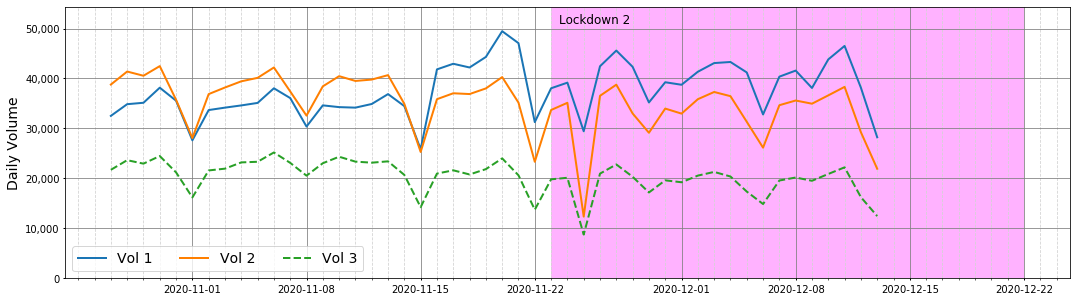

In [11]:
multi_linechart(df_multi, sett)

## Example: one shaded area with no legend
In this case, simply do not include `legend` in the settings dict.  

In [12]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 14
    },
    
    # Axes labels and limits
    'ylab': 'Daily Volume',
    'xlab': 'Day',
    'major_loc': {
        'loc': mdates.DayLocator(),
        'fmt': mdates.DateFormatter('%d %b %Y')
    },
    'minor_loc': mdates.DayLocator(interval=1),  # every other day
    
    # legend
#     'legend': {
#         'loc': 'lower left'
#     },

    'lines': {
        0: {
            'stroke': '#1A75B5',
            'border-style': 'solid',
            'label': 'Vol 1'
            },
        1: {
            'stroke': '#FF7F00',
            'border-style': 'solid',
            'label': 'Vol 2'
            },
        2: {
            'stroke': '#28A026',
            'border-style': 'dashed',
            'label': 'Vol 3'
            }
    },
    
    'shaded': {
        0: {
            'lims':[[pd.to_datetime('2020-11-23'), pd.to_datetime('2020-12-22')]],
            'fill': 'magenta',
            'zorder':-100,
            'alpha': 0.3,
            'label': {
                'x': pd.to_datetime('2020-11-23') + datetime.timedelta(days=.5),
                'y': 51000,
                'text': 'Lockdown 2',
                'fontsize': 12, 
                'colour': 'k',
                'rotation': 0
            }
        }
    }
}

findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans.


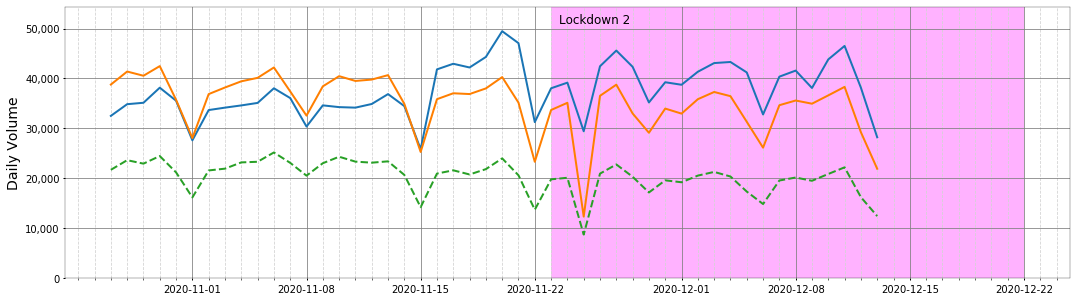

In [13]:
multi_linechart(df_multi, sett)

## Example: one shaded area block and shaded weekends

In [14]:
def find_weekend_indices(df):
    '''Outputs a 2D list of weekend date pairs given date column
    in df. Assumes first column of df is the date column. 
    Datetime pairs output in `datetime.date()` format.
    '''
    xcol=list(df)[0]
    datetime_array=df[xcol]
    
    s = []
    for i in range(len(datetime_array) - 1):
        if datetime_array[i].weekday() >= 5:
            s.append([df[xcol][i], df[xcol][i + 1]])

    return s

In [15]:
sett = {
    'body': {
        'font-family':'Libre Franklin',
        'font-size': 14
    },
    
    # Axes labels and limits
    'ylab': 'Daily Volume',
    'xlab': 'Day',
    'major_loc': {
        'loc': mdates.DayLocator(),
        'fmt': mdates.DateFormatter('%d %b %Y')
    },
    'minor_loc': mdates.DayLocator(interval=1),  # every other day
    
    # legend
    'legend': {
        'loc': 'lower left'
    },

    'lines': {
        0: {
            'stroke': '#1A75B5',
            'border-style': 'solid',
            'label': 'Vol 1'
            },
        1: {
            'stroke': '#FF7F00',
            'border-style': 'solid',
            'label': 'Vol 2'
            },
        2: {
            'stroke': '#28A026',
            'border-style': 'dashed',
            'label': 'Vol 3'
            }
    },
    
    'shaded': {
        0: {
            'lims':[[pd.to_datetime('2020-11-23'), pd.to_datetime('2020-12-22')]],
            'fill': 'magenta',
            'zorder':-100,
            'alpha': 0.3,
            'label': {
                'x': pd.to_datetime('2020-11-23') + datetime.timedelta(days=.5),
                'y': 51000,
                'text': 'Lockdown 2',
                'fontsize': 12, 
                'colour': 'k',
                'rotation': 0
            }
        },
        1:{
            'lims':find_weekend_indices(df_multi),
            'fill': '#ccffff',
            'alpha': 0.9 
        }
    }
}

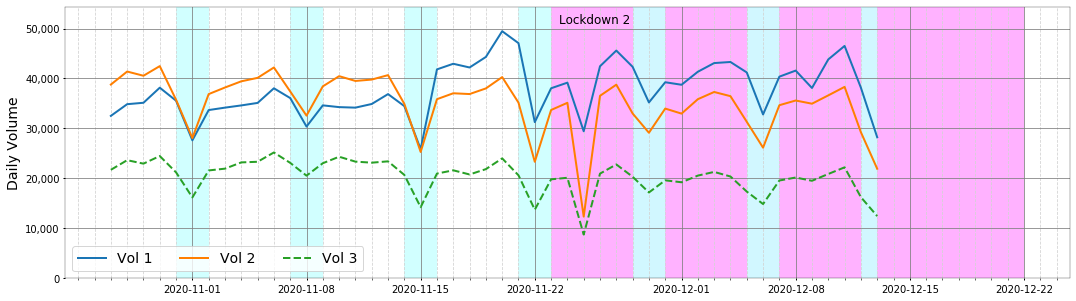

In [16]:
multi_linechart(df_multi, sett)

# Test 2

In [17]:
def get_weekly():
    ''' Get weekly travel times for report segment level  
    
    '''
 
    weekly_sql = '''
    select *, from_street||' to '||to_street as from_to from activeto.mjr_report_tt_weekly
    where week > '2020-02-03'
      '''
    with con: 
        weekly_tt = pandasql.read_sql(weekly_sql, con)  
    
    return weekly_tt